# Import Statements

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB4
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.optimizers import Adam
import warnings
import os, cv2, json
from PIL import Image
warnings.simplefilter("ignore")

# Path Variables

In [38]:
TRAIN_IMAGES_PATH = '../input/cassava-leaf-disease-classification/train_images'
LABEL_NUM_TO_DISEASE_NAME_PATH = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
TRAIN_CSV_PATH = '../input/cassava-leaf-disease-classification/train.csv'

# Dataset Files Details

In [39]:
print('Train images: %d' %len(os.listdir(
    TRAIN_IMAGES_PATH)))
print("\n-----------------------------------------------------------------------------\n")
with open(LABEL_NUM_TO_DISEASE_NAME_PATH) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

Train images: 21397

-----------------------------------------------------------------------------

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [40]:
train_labels = pd.read_csv(TRAIN_CSV_PATH)
print(train_labels.head())
print("\n-----------------------------------------------------------------------------\n")
print("Count of images per class\n")
train_labels.label.value_counts()

         image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

-----------------------------------------------------------------------------

Count of images per class



3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

# Prepare Dataset for Binary Classification

In [41]:
CLASS_NUM = 3

In [42]:
def prepare_data_for_binary_classification(class_num,print_info=True):
    label = []
    for i in train_labels["label"]:
        if i ==class_num: #Change
            label.append(1)
        else:
            label.append(0)
    train_labels["label"] = label
    
    if(print_info):
        print(train_labels.label.value_counts())
        
    return train_labels


In [43]:
train_labels = prepare_data_for_binary_classification(class_num = CLASS_NUM)

1    13158
0     8239
Name: label, dtype: int64


# Preparation for modeling

In [44]:
# Main parameters
BATCH_SIZE = 4
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 380

### ImageDataGenerator

In [45]:
train_labels.label = train_labels.label.astype('str')

train_datagen = ImageDataGenerator( 
                                    validation_split = 0.20,
                                     rotation_range = 30,
                                     zoom_range = 0.15,
                                     horizontal_flip = True,
                                     vertical_flip = True,
                                     brightness_range=[0.4,1.4],
                                     fill_mode = 'nearest')

train_generator = train_datagen.flow_from_dataframe(train_labels,
                         directory =TRAIN_IMAGES_PATH,
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE, 
                         class_mode= 'binary')


validation_datagen = ImageDataGenerator( validation_split = 0.20)

validation_generator = validation_datagen.flow_from_dataframe(train_labels,
                         directory = TRAIN_IMAGES_PATH,
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE, 
                         class_mode= 'binary')

Found 17118 validated image filenames belonging to 2 classes.
Found 4279 validated image filenames belonging to 2 classes.


In [46]:
from collections import Counter

train_items = Counter(train_generator.classes)
print(f'Images per class in train set : {train_items}')

test_items = Counter(validation_generator.classes)
print(f'Images per class in test set : {test_items}')

Images per class in train set : Counter({1: 10520, 0: 6598})
Images per class in test set : Counter({1: 2638, 0: 1641})


# Modeling

In [ ]:
def create_model():

    conv_base = EfficientNetB4(include_top = False, 
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    conv_base.trainable = True
    model = conv_base.output
    model = layers.Flatten()(model)
    model = layers.Dense(256, activation = "relu")(model)
    model = layers.Dropout(0.2)(model)
    model = layers.Dense(1, activation = "sigmoid")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.0001),
                  loss = "binary_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
model = create_model()
model.summary()

### Loading weights

In [47]:
MODEL_BEST_WEIGHTS_PATH = f'Models/1v4/Class {CLASS_NUM}/NO undersample B4 20 epoch/Trainable True/Class{CLASS_NUM}_EffNetB4_380_4_20_epoch_best_weights.h5'
MODEL_NUMPY_WEIGHTS_PATH = f"Models/1v4/Class {CLASS_NUM}/NO undersample B4 20 epoch/Trainable True/B4_Numpy_Weights"
MODEL_PATH = f'Models/1v4/Class {CLASS_NUM}/NO undersample B4 20 epoch/Trainable True/Model_Class_{CLASS_NUM}_EffNetB4_380_20epoch.h5'
MODEL_SAVED_WEIGHTS_PATH = f'Models/1v4/Class {CLASS_NUM}/NO undersample B4 20 epoch/Trainable True/B4_SavedWeights.hdf5'
MODEL_RELOAD_PATH = '../input/models/Model_Class_3_EffNetB4_380_20epoch.h5'

In [ ]:
model_save = ModelCheckpoint(MODEL_BEST_WEIGHTS_PATH, #Change
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_acc', 
                             mode = 'max', verbose = 1)

early_stop = EarlyStopping(monitor = 'val_acc', 
                           patience = 2, mode = 'max', verbose = 1,
                           restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', factor = 0.1, 
                              patience = 1, 
                              mode = 'max', verbose = 1)
history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']                                              
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "b", label = "Training acc", color='red')
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "b", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'blue')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

# Save Model

In [ ]:
weights = model.get_weights()
np.save(MODEL_NUMPY_WEIGHTS_PATH, weights) 
model.save(MODEL_PATH)
model.save_weights(MODEL_SAVED_WEIGHTS_PATH)

In [48]:
model_test = tf.keras.models.load_model(MODEL_RELOAD_PATH)
# model_test.summary()

In [49]:
conv_layers = [layer for layer in model_test.layers  if 'Conv2D' in str(layer)]
selected_conv_layers = [conv_layers[i] for i in [19,39,59,79,99,119,139,159]]
selected_conv_layers

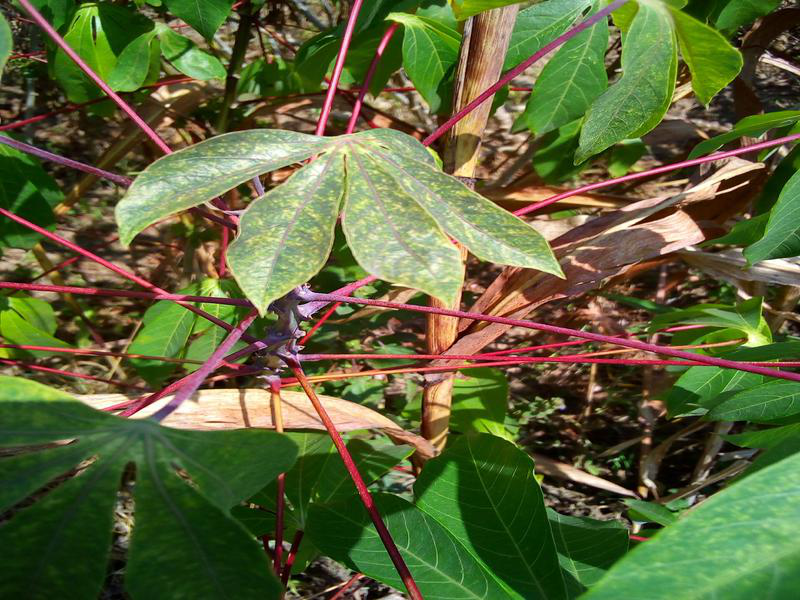

In [66]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
img_path = '../input/cassava-leaf-disease-classification/train_images/1009749557.jpg'
img= Image.open(img_path)
img

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x600 at 0x7FD3F23E8450>


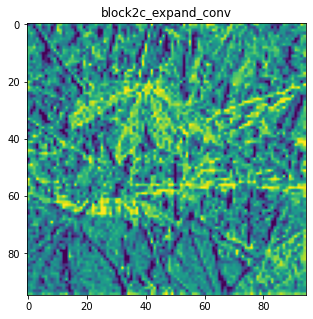

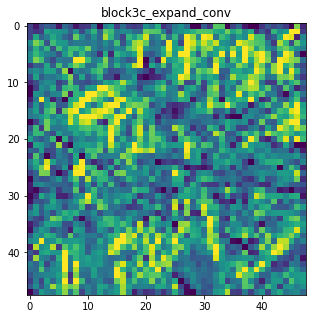

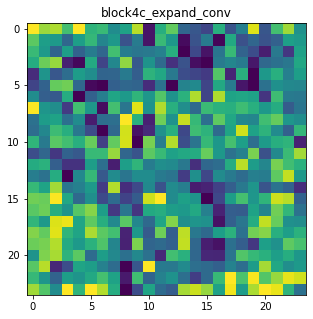

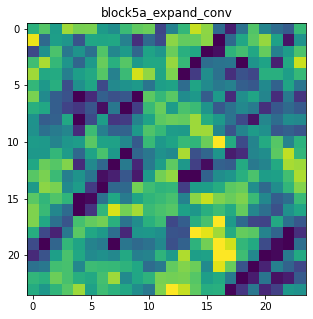

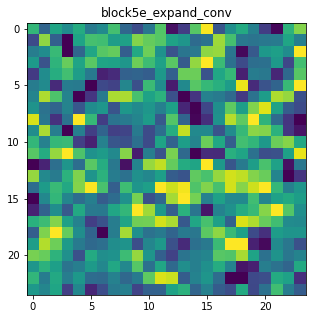

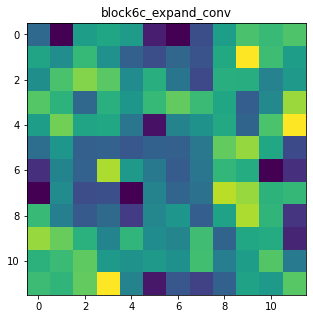

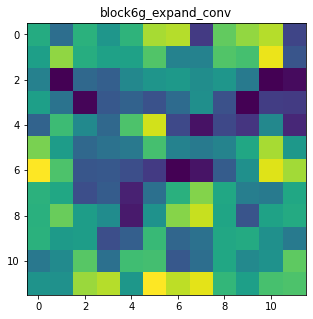

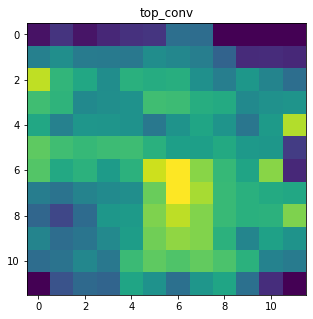

In [65]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img


successive_outputs = [layer.output for layer in selected_conv_layers]

visualization_model = tf.keras.models.Model(inputs = model_test.input, outputs = successive_outputs)

img_path = '../input/cassava-leaf-disease-classification/train_images/1009749557.jpg'
img = load_img(img_path, target_size=(380, 380))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)


# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in selected_conv_layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = 1  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 5./n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


In [ ]:
model_test.evaluate(validation_generator)

In [ ]:
model_test.evaluate(train_generator)